# Diamond EP Grouping by Resolution Limit - Outliers

Previously analysis has shown how most of the features do not follow a normal distribution, and most have significant outliers which might be nonsensical data resulting from the "resolution limit expansion" process done when preprocessing the data.

In this notebook these outliers will try to be identified and somehow removed, which might result in a positive change to predictive model performance.

In [1]:
import sys
dirpath = r'C:\Users\César\PycharmProjects\Diamond_ML'
if dirpath not in sys.path:
    sys.path.insert(0, dirpath)
from read_data import data, pd, np, plt, plot_original_data
plt.style.use("ggplot")

DIALS


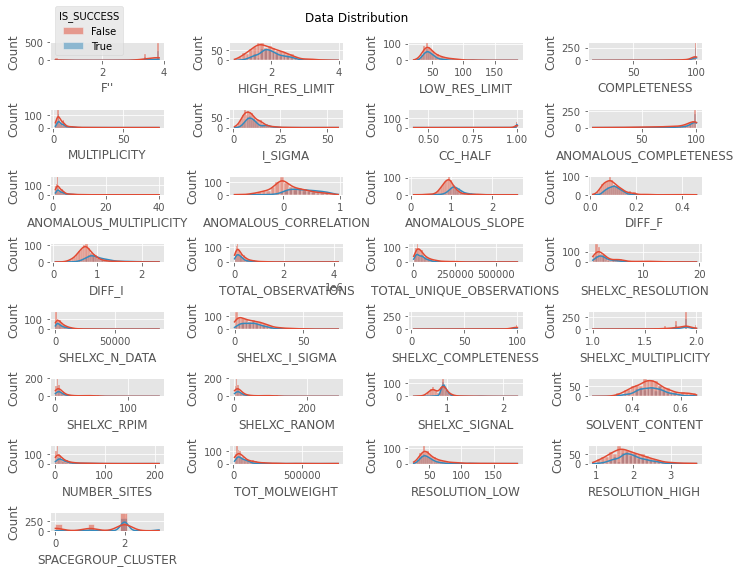

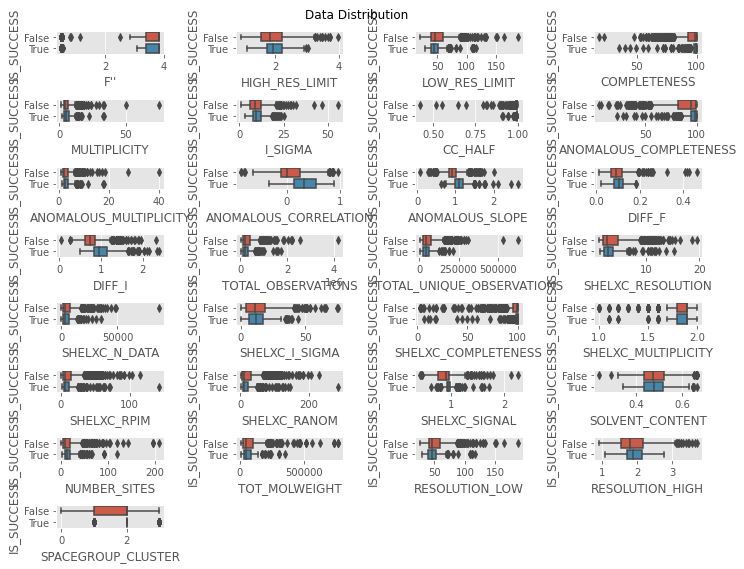

------------------------------------------------------------
3DII


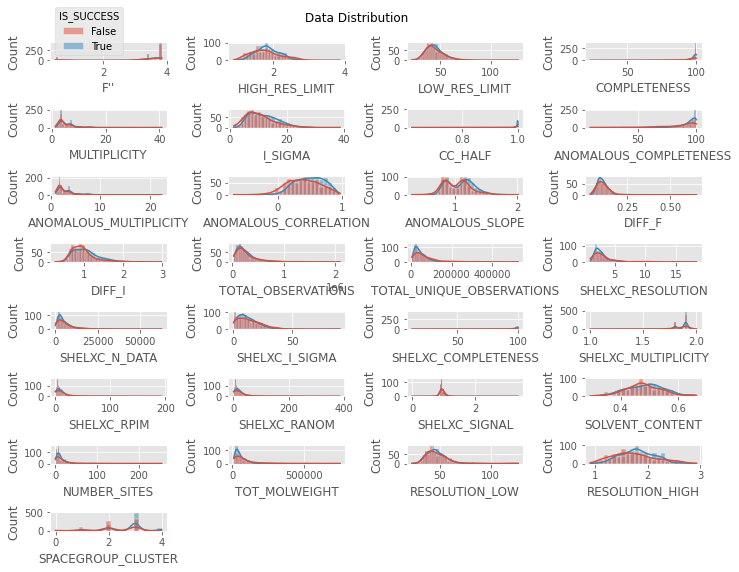

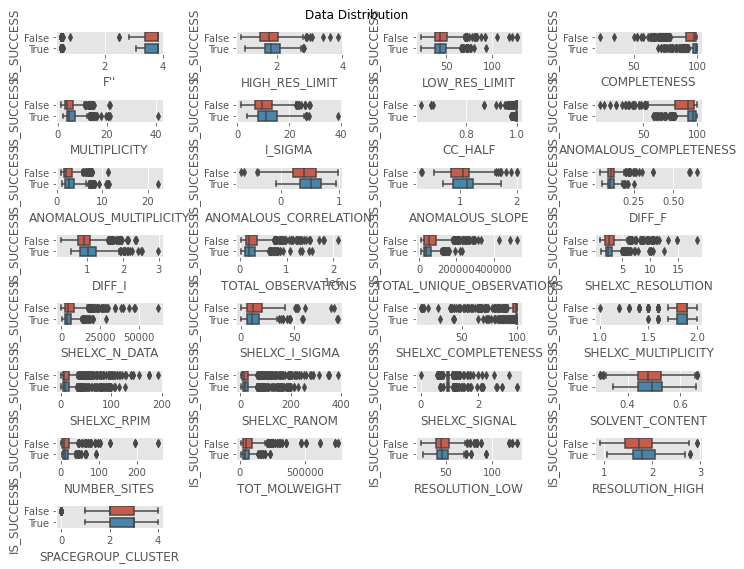

------------------------------------------------------------


In [5]:
from read_data import data, np, pd, plt
from grouping import cluster_spacegroups
from outliers import matrixdistplot
import seaborn as sns
    

for db_kind, datum in data.items():
    print(db_kind.upper())
    r_etc = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x, y, union = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM"] + r_etc, union=True)
    
    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]
    x = x.drop(["DATASET_NAME"], axis=1)
    
    # encode spacegroup to int based on success rate
    n_clusters = 4 if db_kind == "dials" else 5
    _, spc_grp_map, _ = cluster_spacegroups(union, n_clusters)
    x["SPACEGROUP_CLUSTER"] = x["SPACEGROUP"].map(spc_grp_map)
    x = x.drop("SPACEGROUP", axis=1)
    union = pd.concat([x, y], axis=1)

    '''# group data
    groups = GroupedData(x, y)
    groups.group(x["DATASET_NAME"])
    
    # sort groups
    names = x["DATASET_NAME"].unique().tolist()
    names.sort()
    groups.sort(names, inplace=True)
    
    for i, group in groups:
        x, y = group.unpack()'''
    
    # plot histogram/boxplot matrix
    for kind in ["hist", "box"]:
        matrixdistplot(data=union, colnames=x.columns, kind=kind, target_label="IS_SUCCESS", show=False)
    
    plt.show()

    print("-"*60)

Most histograms show a long trail, indicating the presence of **significant outliers**, which is corroborated in the boxplots, showing large amounts of datapoints outside of the 25-75th percentiles.

However, **some features do not follow a normal/gaussian distribution**, such as the resolution limits, f'', dataset name and spacegroup cluster. These features possess discrete and/or clustered values, so outlier removal methods based on gaussian distributions should **not** be used with them. Instead, for these, a clustering method, such as LOC or Isolation Forests should be used.

It's important to realise that this is the case even for the "untouched" dataset.

Melanie's guess is that "the outliers are non-sense data were the actual measurement didn’t reach the resolution limits we asked the software to use". To check this, the dataset resolution label and the actual resolution limits need to be be compared.

## Method 1 - Dataset/Limit Resolution Difference

In this method, the difference between the dataset resolution label (the resolution it should be, aka "RESOLUTION_LOW/HIGH"), and the actual resolution limit (aka "LOW/HIGH_RES_LIMIT") is taken. If this difference is above a predefined threshold, the sample is taken to be erroneous, and an **outlier**.

In the following analysis thresholds of 5 for the LR, and 0.1 for the HR were used.

However, if this method does successfully eliminate outliers, then these result from a software error, where it was unable to reach the resolution limit asked from it.

DIALS


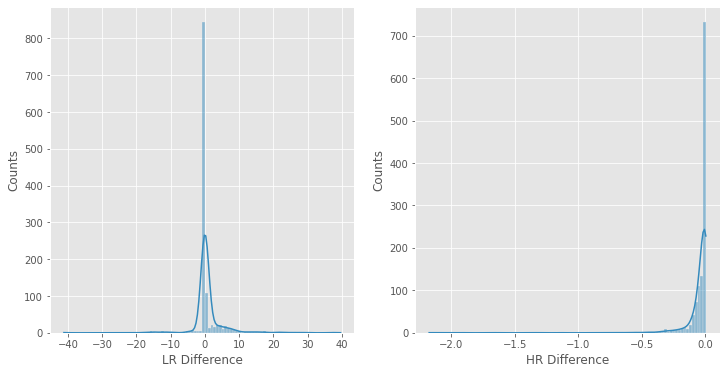

OG:
> Low: 1201 samples - MSE: 23.74
> High: 1201 samples - MSE: 0.0191
Masked:
> Low: 1074 samples - Dropped 127 (10.57%) - MSE: 1.21
> High: 1074 samples - Dropped 127 (10.57%) - MSE: 0.0009
No. of common outliers: 13
In total dropped 241 samples (20.07%)
Score: OG = 81.63% +- 2.39% vs New = 82.36% +- 0.82%


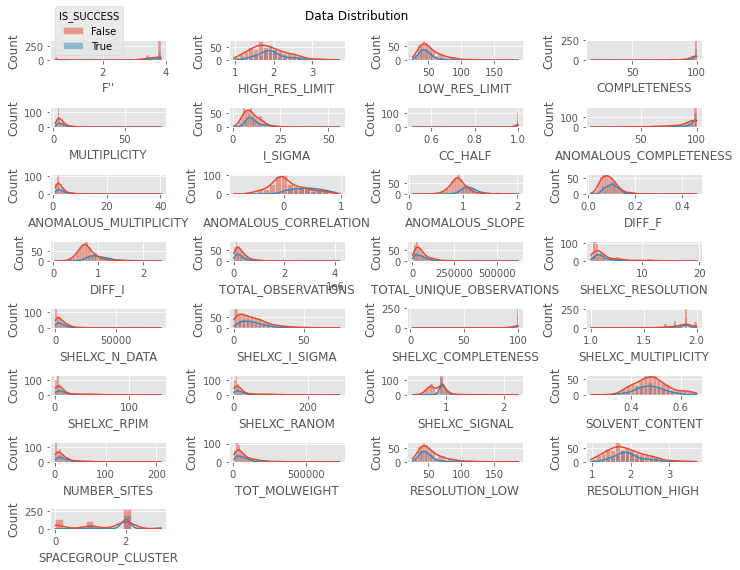

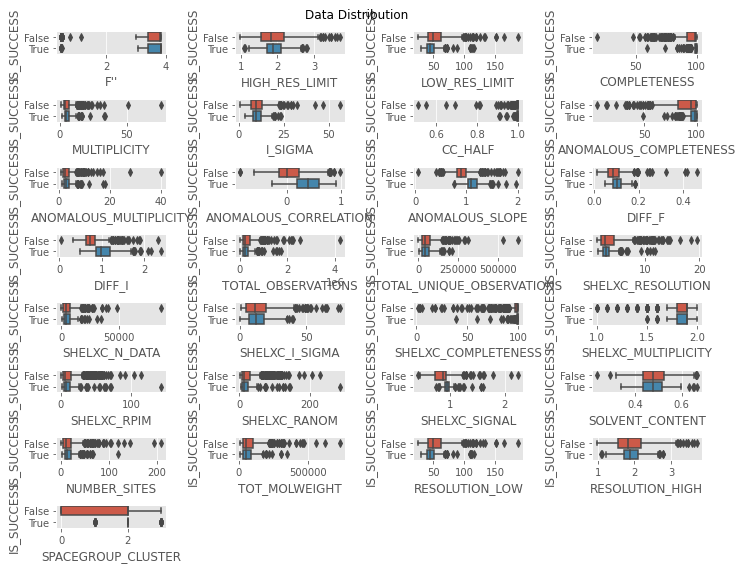

------------------------------------------------------------
3DII


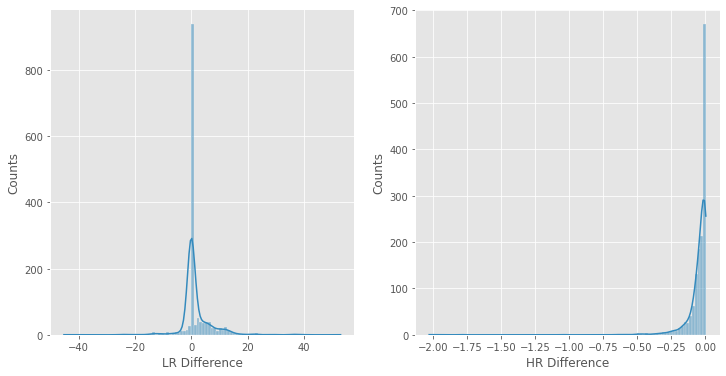

OG:
> Low: 1450 samples - MSE: 35.65
> High: 1450 samples - MSE: 0.0130
Masked:
> Low: 1167 samples - Dropped 283 (19.52%) - MSE: 1.66
> High: 1282 samples - Dropped 168 (11.59%) - MSE: 0.0013
No. of common outliers: 32
In total dropped 419 samples (28.90%)
Score: OG = 88.24% +- 1.10% vs New = 87.74% +- 0.52%


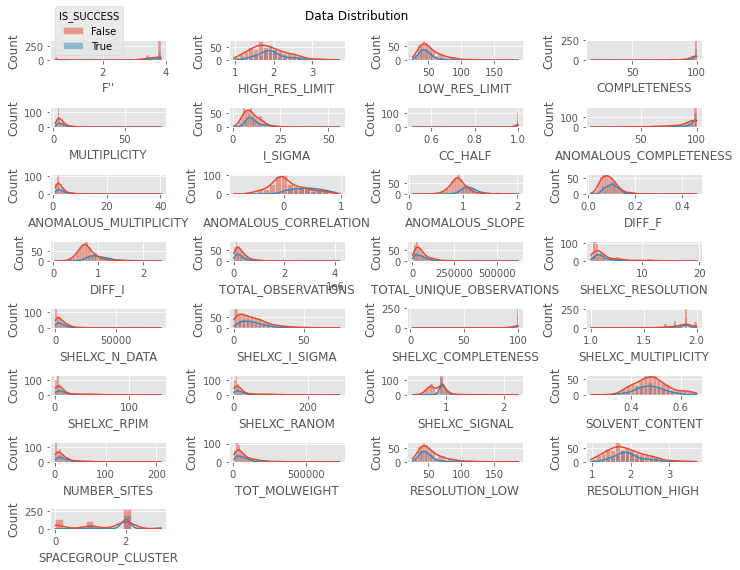

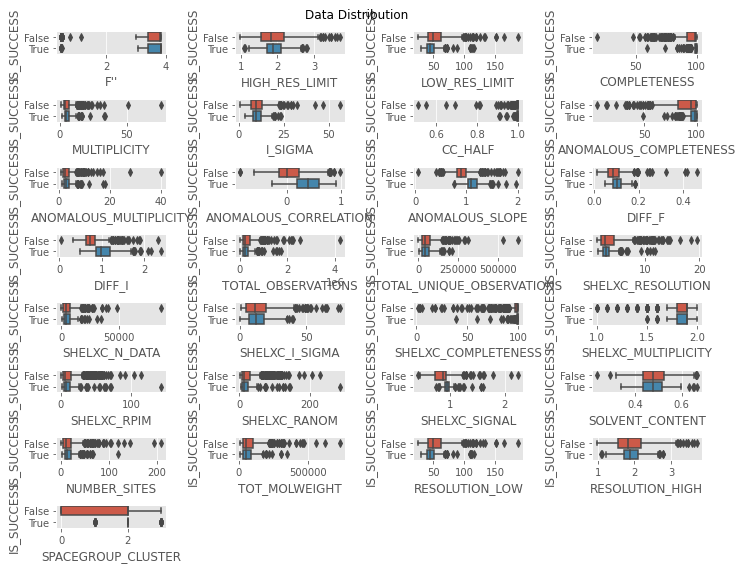

------------------------------------------------------------


In [26]:
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from scipy.stats import sem


for db_kind, datum in data.items():
    print(db_kind.upper())
    r_etc = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x, y, union = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM"] + r_etc, union=True)
    
    # encode spacegroup to int based on success rate
    n_clusters = 4 if db_kind == "dials" else 5
    _, spc_grp_map, _ = cluster_spacegroups(union, n_clusters)
    x["SPACEGROUP_CLUSTER"] = x["SPACEGROUP"].map(spc_grp_map)
    
    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]
    x = x.drop(["DATASET_NAME", "SPACEGROUP"], axis=1)
    union = pd.concat([x, y], axis=1)
    
    # fit initial model
    seed = 1
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    model = Pipeline([("scaler", StandardScaler()), ("forest", RandomForestClassifier(random_state=seed))])
    scores_og = cross_val_score(model, x, y, scoring="f1", cv=cv, n_jobs=4)
    
    # see difference between dataset resolutions and actual resolutions
    diff_low = x["RESOLUTION_LOW"] - x["LOW_RES_LIMIT"]
    diff_high = x["RESOLUTION_HIGH"] - x["HIGH_RES_LIMIT"]
    fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(12, 6))
    sns.histplot(data=diff_low, ax=ax_left, kde=True, bins=100)
    sns.histplot(data=diff_high, ax=ax_right, kde=True, bins=100)
    ax_left.set_xlabel("LR Difference");  ax_right.set_xlabel("HR Difference")
    ax_left.set_ylabel("Counts");  ax_right.set_ylabel("Counts")
    plt.show()

    # get initial MSE and find outliers based on simple threshold for resolution difference
    thresh_low, thresh_high = 5, 0.1
    mse_low = (diff_low ** 2).mean()
    mse_high = (diff_high ** 2).mean()
    good_low_mask = abs(diff_low) < thresh_low
    good_high_mask = abs(diff_high) < thresh_high

    # get stats for new, filtered resolution differences
    good_diff_low = diff_low[good_low_mask]
    good_diff_high = diff_high[good_high_mask]
    dropped_low = diff_low.size - good_diff_low.size
    dropped_high = diff_high.size - good_diff_high.size
    mse_good_low = (good_diff_low ** 2).mean()
    mse_good_high = (good_diff_high ** 2).mean()
    bad_mask = (np.logical_or(~good_low_mask, ~good_high_mask))

    # print results and stats
    print(f"OG:\n> Low: {diff_low.size} samples - MSE: {mse_low:.2f}\n"
          f"> High: {diff_high.size} samples - MSE: {mse_high:.4f}\n"
          f"Masked:\n> Low: {good_diff_low.size} samples - Dropped {dropped_low} ({dropped_low / diff_low.size:.2%}) - MSE: {mse_good_low:.2f}\n"
          f"> High: {good_diff_high.size} samples - Dropped {dropped_high} ({dropped_high / diff_high.size:.2%}) - MSE: {mse_good_high:.4f}\n"
          f"No. of common outliers: {(np.logical_and(~good_low_mask, ~good_high_mask)).sum()}\n"
          f"In total dropped {bad_mask.sum()} samples ({bad_mask.sum()/bad_mask.size:.2%})")

    # obtain actual outliers and filtered data
    good_mask = np.logical_and(good_low_mask, good_high_mask)
    outliers = union.loc[~good_mask, :]
    union_good = union.loc[good_mask, :]
    
    # fit new model with filtered data
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    model = Pipeline([("scaler", StandardScaler()), ("forest", RandomForestClassifier(random_state=seed))])
    scores_new = cross_val_score(model, x.loc[good_mask, :], y[good_mask], scoring="f1", cv=cv, n_jobs=4)
    print(f"Score: OG = {scores_og.mean():.2%} +- {sem(scores_og):.2%} "
          f"vs New = {scores_new.mean():.2%} +- {sem(scores_new):.2%}")
    
    # show all in histogram and boxplot, for comparison to previous
    for kind in ["hist", "box"]:
        matrixdistplot(normal, colnames=x.columns, target_label="IS_SUCCESS", kind=kind, show=False)
    plt.show()
    
    print("-"*60)

Most samples have 0 difference (optimal), however there are quite a few with observable difference (as seen by the large MSE > 20).

After dropping the large difference samples (~20%/30% for DIALS/XDS), the MSE drops to ~0.1, indicating almost **all of the erroneous resolution samples have been removed**. However, the distributions still look **similar** - most features have a "tail" in their histogram, and a significant amount of outliers in their boxplots.

However, a the following features do show less outliers in their boxplots:

- **Completeness/multiplicity**, and its variations
- **CC half**
- **Anomalous slope**, on its high end (>2)
- **DIFF F/I**
- **I sigma**
- etc.

The effect is stronger (and better) on XDS, since more outliers appear to be removed in this case.

This being said, removing these *outliers* results in **similar predictive performance**, even if slightly lower (tested with random forest), indicating that their removal does not affect model performance by a significant amount.

Care needs to be taken when choosing the LR/HR thresholds, since too small thresholds will remove too much critical data, worsening the performance, and too large thresholds will not remove any data, having no impact on performance.


**Conclusion**: This method successfully removes *some* outliers, while keeping the performance around the same, with slight drops.


## Method 2: IQR Removal

DIALS
OG:
> 1201 samples - Score: 81.63% +- 2.39%
Masked:
> 735 samples - Dropped 466 (38.80%) - Score: 81.59% +- 2.36%


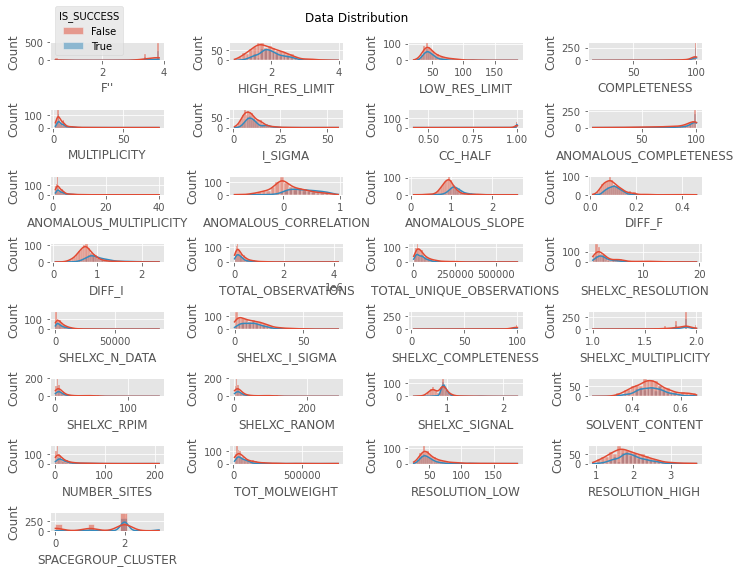

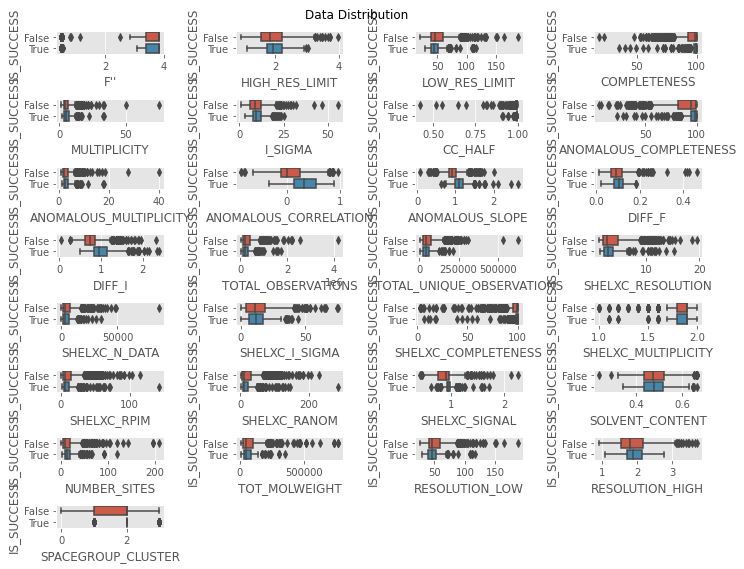

------------------------------------------------------------
3DII
OG:
> 1450 samples - Score: 88.24% +- 1.10%
Masked:
> 931 samples - Dropped 519 (35.79%) - Score: 88.23% +- 1.21%


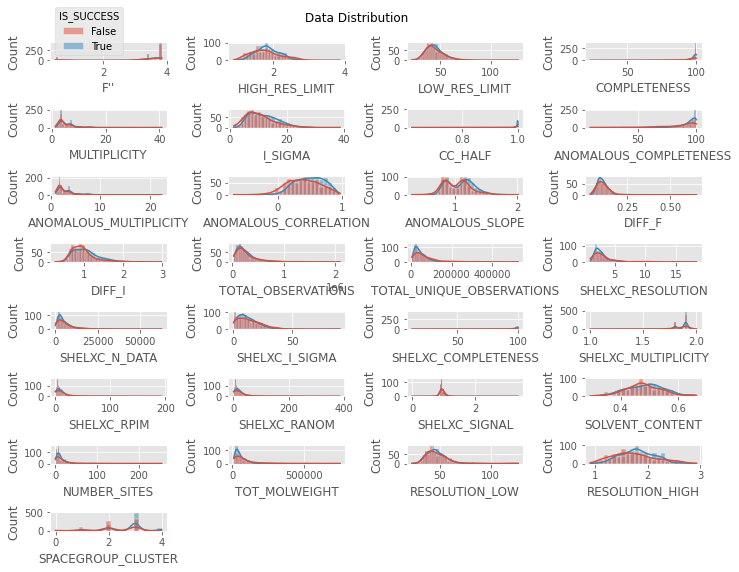

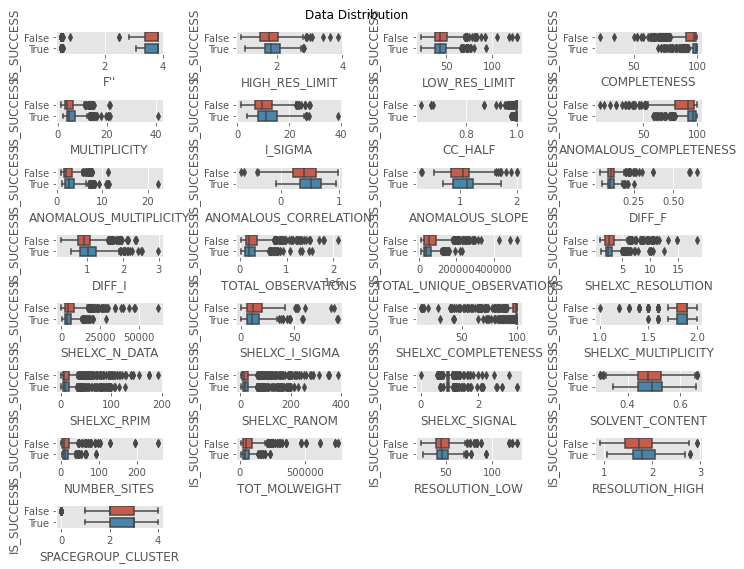

------------------------------------------------------------


In [20]:
for db_kind, datum in data.items():
    print(db_kind.upper())
    r_etc = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x, y, union = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM"] + r_etc, union=True)

    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]

    # encode spacegroup to int based on success rate
    n_clusters = 4 if db_kind == "dials" else 5
    _, spc_grp_map, _ = cluster_spacegroups(union, n_clusters)
    x["SPACEGROUP_CLUSTER"] = x["SPACEGROUP"].map(spc_grp_map)
    x = x.drop(["DATASET_NAME", "SPACEGROUP"], axis=1)
    union = pd.concat([x, y], axis=1)


    # fit initial model
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    model = Pipeline([("scaler", StandardScaler()), ("forest", RandomForestClassifier(random_state=seed))])
    scores_og = cross_val_score(model, x, y, scoring="f1", cv=cv, n_jobs=4)

    # get 25/75th quartiles, iqr and cutoffs for all features
    k = 3
    quarts = x.drop("SPACEGROUP_CLUSTER", axis=1).quantile([0.25, 0.75])
    iqr = quarts.diff(axis=0).iloc[1, :].rename("IQR")
    cut_offs = quarts.copy().rename(index={0.25: "Lower", 0.75: "Upper"})
    cut_offs.iloc[0, :] -= iqr * k
    cut_offs.iloc[1, :] += iqr * k


    def between_series(series, cutoffs_df, inclusive="both"):
        try:  # get values in between cutoffs
            lower, upper = cutoffs_df.loc[:, series.name]
            return series.between(lower, upper, inclusive=inclusive)
        except KeyError:  # if cutoffs not found, return series full of True
            return series == series  # might misbehave with NaN


    # obtain actual outliers and filtered data
    good_mask = x.apply(between_series, axis=0, cutoffs_df=cut_offs).all(axis=1)
    x_new, y_new = x.loc[good_mask, :], y[good_mask]
    n_og, n_new = good_mask.size, good_mask.sum()

   
    # fit new model with filtered data
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    model = Pipeline([("scaler", StandardScaler()), ("forest", RandomForestClassifier(random_state=seed))])
    scores_new = cross_val_score(model, x.loc[good_mask, :], y[good_mask], scoring="f1", cv=cv, n_jobs=4)
    
    # print results and stats
    print(f"OG:\n> {n_og} samples - Score: {scores_og.mean():.2%} +- {sem(scores_og):.2%}\n"
          f"Masked:\n> {n_new} samples - Dropped {n_og-n_new} ({1-n_new/n_og:.2%}) - Score: {scores_new.mean():.2%} +- {sem(scores_new):.2%}")

    
    # show all in histogram and boxplot, for comparison to previous
    for kind in ["hist", "box"]:
        matrixdistplot(union, colnames=x.columns, target_label="IS_SUCCESS", kind=kind, show=False)
    plt.show()

    print("-" * 60)